# Exploratory data anaylsis

## Look at data and clean up one year

In [1]:
import pandas as pd
df = pd.read_excel("../notebooks/Historical Station Counts by State 2007-2021.xlsx", sheet_name='2020', skiprows=1)
df

,State,Biodiesel,CNG,E85,Electrica,Hydrogenb,LNG,Propanec,Totald
0,NaN,NaN,NaN,NaN,(stations / charging outlets,(retail / non-retail / total),NaN,(primary / secondary / total),NaN
1,NaN,NaN,NaN,NaN,Level 1 / Level 2 / DC Fast),NaN,NaN,NaN,NaN
2,Alabama,10.0,30.0,29.0,223 / 596,0 / 0 / 0,2.0,24 / 45 / 69,736.0
3,NaN,NaN,NaN,NaN,56 / 449 / 91,NaN,NaN,NaN,NaN
4,Alaska,0.0,1.0,0.0,25 / 45,0 / 0 / 0,0.0,1 / 2 / 3,49.0
...,...,...,...,...,...,...,...,...,...
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,(a) Includes legacy chargers but does not incl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,(b) Primary propane stations offer vehicle-spe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,(c) Retail hydrogen stations accept payment at...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df.dropna(how="all")
    df_cleaned = df_cleaned.rename(columns={"Totald" : "Total"})
    df_cleaned = df_cleaned[["State", "Total"]]
    df_cleaned = df_cleaned.dropna()
    df_cleaned['State'] = df_cleaned['State'].astype('category')
    return df_cleaned

df_total = pd.DataFrame()
for n in range(2007, 2022, 1):
    df = pd.read_excel("../notebooks/Historical Station Counts by State 2007-2021.xlsx", sheet_name=str(n), skiprows=1)
    df_cleaned = clean_data(df)
    df_cleaned["Year"] = n
    df_total = pd.concat([df_total, df_cleaned])

Get some general info about the data

In [4]:
df_total.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 2 to 104
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   State   780 non-null    category
 1   Total   780 non-null    float64 
 2   Year    780 non-null    int64   
dtypes: category(1), float64(1), int64(1)
memory usage: 21.5 KB


In [5]:
df_total.describe(include='all')

,State,Total,Year
count,780,780.000000,780.000000
unique,52,NaN,NaN
top,Alabama,NaN,NaN
freq,15,NaN,NaN
mean,NaN,1802.579487,2014.000000
std,NaN,8917.620078,4.323266
min,NaN,6.000000,2007.000000
25%,NaN,112.000000,2010.000000
50%,NaN,294.500000,2014.000000
75%,NaN,969.250000,2018.000000


Check how many missing values we have

In [6]:
df_total.isna().mean()

State    0.0
Total    0.0
Year     0.0
dtype: float64

## Training a regression model on all data

In [9]:
from mlwrap.config import MLConfig, TrainingResults
from mlwrap.enums import ProblemType
from mlwrap import runners, scores

df_train = df_total
config = MLConfig(
                problem_type=ProblemType.Regression,
                model_feature_id="Total",
            )
results = runners.train(config, df_train)
scores.print_scores(results.scores)

,value
iterations,[1000]
total_row_count,[780]
active_feature_count,[0]
inactive_feature_count,[0]
mean_abs_error,[2222.967711886277]
median_abs_error,[1194.3618398045105]
norm_mean_abs_error,[9.36811582597999]
norm_median_abs_error,[2.5408148264439054]
mean_squared_error,[41868253.10721551]


Scores are better for states with lower counts if we train a model per state.

It is also cleaner if we just use the Total value for all states.

<AxesSubplot: xlabel='Year'>

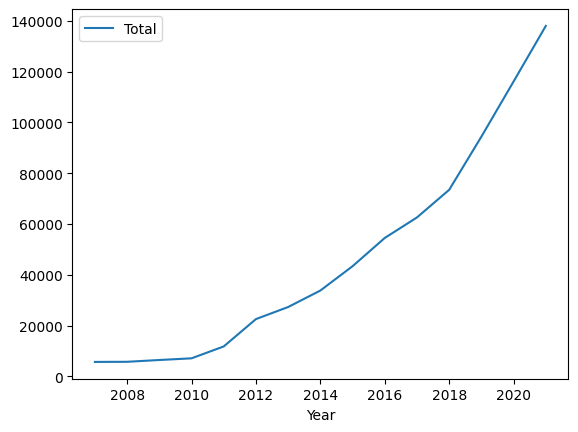

In [30]:
df_train_one_state = df_total.loc[df['State'] == 'Total']
df_train_one_state.plot(x="Year",y="Total")

In [31]:
df_train_one_state = df_train_one_state.drop('State', axis=1)

In [32]:
results_one_state = runners.train(config, df_train_one_state)
scores.print_scores(results_one_state.scores)

,value
iterations,[1000]
total_row_count,[15]
active_feature_count,[0]
inactive_feature_count,[0]
mean_abs_error,[31203.527777777777]
median_abs_error,[20848.58333333333]
norm_mean_abs_error,[0.5169793097157096]
norm_median_abs_error,[0.6262498636773257]
mean_squared_error,[1908416797.006945]


## Add windows features

In [12]:
df_train_window = df_total.loc[df['State'] == 'California']
# df_train = df_train.loc[df_train["Total"] > 20]
df_train_window["TotalLastYear"] = df_train_window["Total"].shift(-1)
df_train_window["TotalNextYear"] = df_train_window["Total"].shift(1)
df_train_window = df_train_window.dropna()
# df_train.plot(x="Year",y="Total")
# df_train_window

/Users/rossparkin/Projects/ak/mlops-intro/.venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [13]:

results_window = runners.train(config, df_train_window)
scores.print_scores(results_window.scores)

,value
iterations,[1000]
total_row_count,[13]
active_feature_count,[0]
inactive_feature_count,[0]
mean_abs_error,[9213.699999999999]
median_abs_error,[11152.099999999999]
norm_mean_abs_error,[6.282361228529832]
norm_median_abs_error,[5.559371884346959]
mean_squared_error,[97313196.67666666]


This works better but it introduces complexities when we think about how it would be implemented because it means that when making predicitions we need to know/guess TotalLastYear and TotalNextYear

## Make a prediction from the one-state model

In [33]:
df_predict = pd.DataFrame({"Year" : 2030}, index=[0])
predictions = results_one_state.model.predict(df_predict)
predictions

array([43409.58333333])